In [154]:
from flask import Flask, render_template, request
import requests
import pandas as pd
import re
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import nltk
from nltk import pos_tag
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
import numpy as np

In [41]:
def parse_for_word(row, keyword):
    has_keyword = 0
    text = row["Review"]
    #print (text + "\n")
    average_sentiment = 0
    for word in text.split(" "):
        if keyword in word:
            has_keyword = 1
    if (has_keyword > 0):
        sentence_list, average_sentiment = get_sentences_with_word(text, keyword)
    else:
        sentence_list = []
        combined_score = 0
    return has_keyword, sentence_list, average_sentiment

def get_sentences_with_word(text, keyword):
    average_sentiment = 0
    number_of_sentences = 0
    list_of_sentences = []
    #print(text)
    sentences = tokenize.sent_tokenize(text)
    for sentence in sentences:
        #print (sentence)
        if keyword in sentence:
            list_of_sentences.append(sentence)
            number_of_sentences = number_of_sentences + 1
            sentiment = get_sentiment(sentence)
            #print(sentence, sentiment)
    average_sentiment = float(sentiment / number_of_sentences)
    return list_of_sentences, average_sentiment

def get_sentiment(text):
    sentiment = SentimentIntensityAnalyzer() #### calling Intensity Analyzer
    compound = sentiment.polarity_scores(text)['compound']  ### calling the 'compound' score for the "text" entered
    #if compound > 0:
    #    return 1  ## positive
    #else:
    #    return 0 ## negative
    #else:
        #return "Neutral"     
    #print(compound)
    return compound

In [42]:
f=open("db.txt", "r")
contents=0
if not(contents):
    contents = f.read()
username = contents.split("\n")[0]
password = contents.split("\n")[1]
dbname_photos = 'photos_db'
dbname_reviews = "reviews_db"

In [43]:
con = psycopg2.connect(database = dbname_reviews, user = username, password = password, port=5432, host= "/var/run/postgresql/")
sql_query_reviews = """
SELECT * FROM reviews_data_table;
"""
reviews_data_from_sql = pd.read_sql_query(sql_query_reviews,con)
con.close()

In [44]:
keyword = "parking"

In [45]:
reviews_data_from_sql = reviews_data_from_sql.drop(axis = 1, columns=["index"])
print(reviews_data_from_sql.shape)
print(reviews_data_from_sql.drop_duplicates().shape)
reviews_data_from_sql = reviews_data_from_sql.drop_duplicates()

(16111, 3)
(16111, 3)


In [46]:
%%time
reviews_data_from_sql["has_keyword"], reviews_data_from_sql["sentence_list"], reviews_data_from_sql["average_sentiment_sentence"] = zip(*reviews_data_from_sql.apply(parse_for_word, keyword = keyword, axis=1))

CPU times: user 4.3 s, sys: 812 ms, total: 5.11 s
Wall time: 5.31 s


In [47]:
reviews_data_from_sql.head()

,Review,Title,sentiment_vader,has_keyword,sentence_list,average_sentiment_sentence
0,Love this salon! I was referred over by two of...,Urban Betty,0.9746,0,[],0.0
1,Came in for a summer haircut since my hair was...,Urban Betty,0.9560,0,[],0.0
2,I recently moved and have been looking for a g...,Urban Betty,-0.9035,0,[],0.0
3,Y'all stop what you are doing right now and go...,Urban Betty,0.9911,0,[],0.0
4,"Love, love, love this place! I saw Holly and s...",Urban Betty,0.9844,0,[],0.0


In [48]:
# remove rows where the keyword doesn't occur
reviews_data_from_sql = reviews_data_from_sql[reviews_data_from_sql.has_keyword != 0]
reviews_data_from_sql.head()
reviews_data_from_sql.iloc[0][5]

0.0

In [49]:
d = {'has_keyword':'has_keyword_sum', 'average_sentiment_sentence':'average_sentiment_sentence_average',
     'sentiment_vader':'sentiment_vader_average', 'sentence_list':'sentence_list_combined',
     'Review': 'Review_sum'}
sorted_mean_by_Title=reviews_data_from_sql.groupby('Title', as_index = False).agg({'has_keyword':'sum',
                                                                'average_sentiment_sentence':'mean',
                                                                'sentiment_vader':'mean',
                                                                'sentence_list':'sum',
                                                                'Review':'sum'}).rename(columns=d)
sorted_mean_by_Title.sort_values(by=['has_keyword_sum'], ascending=False, inplace=True)
sorted_mean_by_Title.head(5)

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum
92,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...
59,Jose Luis Salon & Boutique,16,0.454506,0.940750,[I never had an issue finding a parking spot i...,Surprised I have not written a review since I ...
149,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...
35,Frenchy’s Beauty Parlor,12,-0.000896,0.782808,[I would highly recommend a trip to Frenchy's ...,An overdue review for Sandy! As an Austin newb...
139,Urban Betty,11,0.295627,0.954182,"[When I arrived, parking was convenient as was...",Just finished up with my appointment with Tara...


In [51]:
def scaled_combined_score(row):
    # get the values
    sentiment_score = float(row["average_sentiment_sentence_average"])
    has_keyword_sum = int(row["has_keyword_sum"])
    sentiment_vader = float(row["sentiment_vader_average"])
    # update the sentiment value
    return (combined_function(has_keyword_sum, sentiment_score, sentiment_vader))

def combined_function(has_keyword_sum, sentiment_score, sentiment_vader):
    weight = 0
    if (has_keyword_sum >= 3):
        weight = 0.7
    else:
        alpha = -0.07777
        beta = 0.46666
        weight = alpha * has_keyword_sum * has_keyword_sum + beta * has_keyword_sum
        #print(weight)
    #print(weight, sentiment_score, sentiment_vader)
    return weight * sentiment_score + 0.3 * sentiment_vader

In [52]:
sorted_mean_by_Title['final_score'] = sorted_mean_by_Title.apply(scaled_combined_score, axis=1)
sorted_review_data = sorted_mean_by_Title.sort_values(by=['final_score'], ascending=False)
sorted_review_data.head(15)

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score
137,Thomas Saverio Salon,2,0.858550,0.988300,"[Another Kerastase salon, Thomas Serverio is v...","My beautiful and talented hair wizard, Jessica...",0.830714
140,Urban Hair,4,0.751550,0.984325,"[The atmosphere is great, Nissa is amazing at ...","I LOVE NISSA. The atmosphere is great, Nissa i...",0.821382
133,The Rusty Shears,2,0.824700,0.936850,"[Plenty of parking, relaxing environment, Very...",Justin was very personable and professional. H...,0.794216
153,Zig Zag Salon,2,0.778100,0.990150,[Note this salon has parking and offers compli...,Three cheers for Katie at Zig Zag! I work at F...,0.781210
62,L7 Salon,6,0.686400,0.986517,"[And best of all, you won't have to empty your...",Jillian does an incredible job with blonde hig...,0.776435
105,Salon Hush,2,0.747250,0.988700,"[The salon itself is very nice, they use high ...",Do yourself a favor and see Jamie Kalina! She'...,0.761579
142,Vanity Salon & Day Spa,3,0.644867,0.984567,"[The salons vibe is cozy, located in a charmin...",I stumbled upon Vanity Salon at the Hill Count...,0.746777
30,Dry Society Styling Lounge,4,0.641713,0.984900,[i don't want to park in a parking garage and ...,after trying out 5 places around austin that o...,0.744669
150,West End Salon,6,0.644083,0.979250,"[Very easy to find parking, and the little hou...",I've been raving about the talent and wonderfu...,0.744633
10,Bandit Salon,2,0.718550,0.975800,"[Great location, TONS of parking!, There was p...",I love Bandit! I see Mercedes Mancillas and sh...,0.739851


In [53]:
sorted_review_data.iloc[0][6]

0.8307141519999999

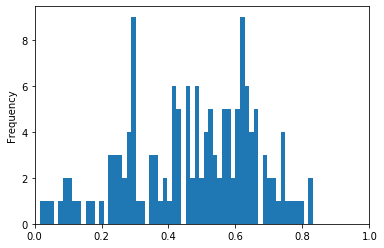

In [54]:
sorted_mean_by_Title.final_score.plot.hist(bins = 100, xlim=[0, 1])

In [57]:
list_of_salons_titles_from_insta = ['Urban Betty', 'Method.Hair', 'Red Stella Hair Salon', 'Topaz Salon', 'Garbo A Salon and Spa',
                                        "Frenchy's Beauty Parlor", 'Black Orchid Salon', 'CNN Hair Team Salon', 'Chuck Edwards The Salon',
                                        'Benjamin Beau Salon', 'Vain', 'Love + Roots', 'Wild Orchid Salon', 'Salon Sovay', 'The Salon at The Domain',
                                        'Ritual Salon', 'Bella Salon', 'SALON by milk + honey', 'Path Salon', 'WaterStone Salon']
type(list_of_salons_titles_from_insta)

list

In [60]:
sorted_review_data["in_insta"] = sorted_review_data.Title.isin(list_of_salons_titles_from_insta)
sorted_review_data.head()

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
137,Thomas Saverio Salon,2,0.85855,0.988300,"[Another Kerastase salon, Thomas Serverio is v...","My beautiful and talented hair wizard, Jessica...",0.830714,False
140,Urban Hair,4,0.75155,0.984325,"[The atmosphere is great, Nissa is amazing at ...","I LOVE NISSA. The atmosphere is great, Nissa i...",0.821382,False
133,The Rusty Shears,2,0.82470,0.936850,"[Plenty of parking, relaxing environment, Very...",Justin was very personable and professional. H...,0.794216,False
153,Zig Zag Salon,2,0.77810,0.990150,[Note this salon has parking and offers compli...,Three cheers for Katie at Zig Zag! I work at F...,0.781210,False
62,L7 Salon,6,0.68640,0.986517,"[And best of all, you won't have to empty your...",Jillian does an incredible job with blonde hig...,0.776435,False


In [62]:
salon_data_with_insta_df = sorted_review_data[sorted_review_data.in_insta == True]
salon_data_with_insta_df.head()

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
149,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
110,Salon Sovay,4,0.569700,0.966400,[The parking lot I will say is super small and...,I was recommend to check this place out from y...,0.688710,True
92,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
94,Ritual Salon,11,0.419073,0.966964,[The parking spot is in the back of the salon....,I'm freshly new in Austin and i booked a last ...,0.583440,True
20,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True


In [63]:
salon_data_with_insta_df.iloc[0][0]

'WaterStone Salon'

In [73]:
con = psycopg2.connect(database = "photos_db", user = username, password = password, port=5432, host= "/var/run/postgresql/")
sql_query_photos = """
SELECT * FROM photos_data_table;
"""
insta_data_from_sql = pd.read_sql_query(sql_query_photos,con)
con.close()

In [74]:
insta_data_from_sql.drop(columns=["index"], inplace=True)

In [75]:
insta_data_from_sql.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence
0,2018-02-04_14-34-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([2.9389e-04, 5....",colored,0.49703
1,2018-02-04_14-42-09_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([5.8816e-04, 3....",colored,0.99762
2,2018-02-04_15-01-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.8565e-04, 9.5...",blonde,0.95877
3,2018-02-04_15-03-08_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.4672e-06, 9.9...",blonde,0.99927
4,2018-02-04_15-06-30_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([3.8139e-05, 1....",colored,0.99979


In [76]:
merged_salon_insta = pd.merge(insta_data_from_sql, salon_data_with_insta_df, left_on='salon_name', right_on='Title')

In [77]:
merged_salon_insta.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
0,2018-02-04_14-34-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([2.9389e-04, 5....",colored,0.49703,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
1,2018-02-04_14-42-09_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([5.8816e-04, 3....",colored,0.99762,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
2,2018-02-04_15-01-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.8565e-04, 9.5...",blonde,0.95877,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
3,2018-02-04_15-03-08_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.4672e-06, 9.9...",blonde,0.99927,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
4,2018-02-04_15-06-30_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([3.8139e-05, 1....",colored,0.99979,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True


In [80]:
merged_salon_insta_red = merged_salon_insta[merged_salon_insta.prediction == "black"]

In [81]:
merged_salon_insta_red.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
27,2018-11-06_15-17-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([8.8020e-01, 3.33...",black,0.88020,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
104,2019-05-17_13-18-49_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([6.5030e-01, 1.05...",black,0.65030,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
128,2017-10-10_03-41-31_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([8.0681e-01, 1.19...",black,0.80681,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
131,2017-10-28_12-13-17_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([7.2795e-01, 5.34...",black,0.72795,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
141,2018-02-21_14-24-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([6.7433e-01, 1.58...",black,0.67433,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True


In [82]:
sorted_merged_salon_insta_red = merged_salon_insta_red.sort_values(by=['final_score'], ascending=False)

In [110]:
sorted_merged_salon_insta_red.salon_name.unique()[0]

'WaterStone Salon'

In [94]:
highest_salon = sorted_merged_salon_insta_red.salon_name.unique()[1]

In [95]:
sorted_merged_salon_insta_red.head(5)

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
1240,2018-02-20_23-20-41_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.8780e-01, 1.30...",black,0.98780,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1303,2019-05-23_15-29-41_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([7.7606e-01, 2.78...",black,0.77606,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1230,2017-11-28_20-38-42_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([0.4705, 0.0461, ...",black,0.47050,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1212,2017-06-23_22-10-31_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([0.6146, 0.0010, ...",black,0.61460,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1249,2018-03-29_19-16-12_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.2139e-01, 1.19...",black,0.92139,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True


In [98]:
sorted_merged_salon_insta_red_highest = sorted_merged_salon_insta_red[sorted_merged_salon_insta_red.salon_name == highest_salon]
sorted_merged_salon_insta_red_highest

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
670,2019-05-03_04-33-56_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5786e-01, 9.81...",black,0.95786,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
719,2019-06-11_23-49-17_UTC_6.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([6.5062e-01, 3.87...",black,0.65062,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
691,2019-05-20_16-26-26_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.9514e-01, 3.26...",black,0.99514,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
683,2019-05-11_18-20-45_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.4213e-01, 1.57...",black,0.94213,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
677,2019-05-07_16-02-02_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5756e-01, 1.07...",black,0.95756,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
697,2019-05-28_18-05-47_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([7.0635e-01, 3.23...",black,0.70635,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True


In [99]:
confidence_ranked_merged_salon_insta_red_highest = sorted_merged_salon_insta_red_highest.sort_values(by=['confidence'], ascending=False)
confidence_ranked_merged_salon_insta_red_highest.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
691,2019-05-20_16-26-26_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.9514e-01, 3.26...",black,0.99514,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
670,2019-05-03_04-33-56_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5786e-01, 9.81...",black,0.95786,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
677,2019-05-07_16-02-02_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5756e-01, 1.07...",black,0.95756,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
683,2019-05-11_18-20-45_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.4213e-01, 1.57...",black,0.94213,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
697,2019-05-28_18-05-47_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([7.0635e-01, 3.23...",black,0.70635,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True


In [121]:
confidence_ranked_merged_salon_insta_red_highest.iloc[0][13]

0.6106565625

# Start new section to find a ranked list of the highest scores for photos #

In [125]:
merged_salon_insta_red.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
27,2018-11-06_15-17-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([8.8020e-01, 3.33...",black,0.88020,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
104,2019-05-17_13-18-49_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([6.5030e-01, 1.05...",black,0.65030,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
128,2017-10-10_03-41-31_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([8.0681e-01, 1.19...",black,0.80681,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
131,2017-10-28_12-13-17_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([7.2795e-01, 5.34...",black,0.72795,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
141,2018-02-21_14-24-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([6.7433e-01, 1.58...",black,0.67433,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True


In [164]:
sorted_merged_salon_insta_red = merged_salon_insta_red.sort_values(by=['final_score'], ascending=False)
sorted_merged_salon_insta_red_good_score = sorted_merged_salon_insta_red[sorted_merged_salon_insta_red.confidence >= 0.8]


In [166]:
sorted_merged_salon_insta_red_good_score.shape

(33, 15)

In [168]:
sorted_merged_salon_insta_red_good_score.head(50)

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
1240,2018-02-20_23-20-41_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.8780e-01, 1.30...",black,0.98780,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1249,2018-03-29_19-16-12_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.2139e-01, 1.19...",black,0.92139,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1287,2019-01-09_00-54-07_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([8.6568e-01, 3.72...",black,0.86568,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1302,2019-05-22_14-21-11_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.9572e-01, 1.32...",black,0.99572,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1224,2017-09-26_22-35-09_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.3614e-01, 3.91...",black,0.93614,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1309,2019-06-07_20-47-48_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.8086e-01, 6.97...",black,0.98086,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
670,2019-05-03_04-33-56_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5786e-01, 9.81...",black,0.95786,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
691,2019-05-20_16-26-26_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.9514e-01, 3.26...",black,0.99514,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
683,2019-05-11_18-20-45_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.4213e-01, 1.57...",black,0.94213,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
677,2019-05-07_16-02-02_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5756e-01, 1.07...",black,0.95756,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True


In [169]:
end_photo_list = []
number_of_photos = min(10, sorted_merged_salon_insta_red.shape[0])
indices = np.random.choice(sorted_merged_salon_insta_red.shape[0], size = number_of_photos, replace = False)
print(indices)
for index in indices:
    photo_information = []
    photo_name = sorted_merged_salon_insta_red.iloc[index][0]
    photo_location = "/static/img/" + sorted_merged_salon_insta_red.iloc[index][2] + "/" + photo_name
    instagram_name = sorted_merged_salon_insta_red.iloc[index][2]
    score = sorted_merged_salon_insta_red.iloc[index][13]
    photo_information.extend((photo_location, instagram_name, score))
    end_photo_list.append(photo_information)
print(end_photo_list)

[17 34 40 15 20 29 26 12 16 21]
[['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_7.jpg', 'ritualsalonatx', 0.58344], ['/static/img/urbanbettysalon/2019-04-25_18-35-34_UTC_1.jpg', 'urbanbettysalon', 0.4931936363636364], ['/static/img/wildorchidatx/2019-02-16_15-19-09_UTC_2.jpg', 'wildorchidatx', 0.491545], ['/static/img/redstellasalon/2019-05-28_18-05-47_UTC.jpg', 'redstellasalon', 0.6106565625], ['/static/img/ritualsalonatx/2019-01-22_19-23-35_UTC_1.jpg', 'ritualsalonatx', 0.58344], ['/static/img/benjaminbeausalon/2018-11-06_15-17-04_UTC.jpg', 'benjaminbeausalon', 0.5191283333333334], ['/static/img/cnnhairteam/2019-02-27_02-48-28_UTC.jpg', 'cnnhairteam', 0.5689116666666666], ['/static/img/redstellasalon/2019-05-20_16-26-26_UTC.jpg', 'redstellasalon', 0.6106565625], ['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_3.jpg', 'ritualsalonatx', 0.58344], ['/static/img/ritualsalonatx/2019-01-29_18-39-37_UTC.jpg', 'ritualsalonatx', 0.58344]]


In [175]:
def takeThird(elem):
    return elem[2]
end_photo_list.sort(key=takeThird, reverse=True)
end_photo_list

[['/static/img/redstellasalon/2019-05-20_16-26-26_UTC.jpg',
  'redstellasalon',
  0.6106565625],
 ['/static/img/redstellasalon/2019-05-28_18-05-47_UTC.jpg',
  'redstellasalon',
  0.6106565625],
 ['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_3.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_7.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/ritualsalonatx/2019-01-22_19-23-35_UTC_1.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/ritualsalonatx/2019-01-29_18-39-37_UTC.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/cnnhairteam/2019-02-27_02-48-28_UTC.jpg',
  'cnnhairteam',
  0.5689116666666666],
 ['/static/img/benjaminbeausalon/2018-11-06_15-17-04_UTC.jpg',
  'benjaminbeausalon',
  0.5191283333333334],
 ['/static/img/urbanbettysalon/2019-04-25_18-35-34_UTC_1.jpg',
  'urbanbettysalon',
  0.4931936363636364],
 ['/static/img/wildorchidatx/2019-02-16_15-19-09_UTC_2.jpg',
  'wildorchidatx',
  0.491545]]